# Lecture 17 - LINEAR DATA FITTING WITH UNCERTANTIES - HW 10

In [1]:
#standard importing
from matplotlib import pyplot as plt
import numpy as np
import scipy.optimize as opt

In [2]:
#Read in the data to a numpy array
data = np.genfromtxt("LinearFit_data.txt", names=True, dtype=None)

# print out all columns we just got for free
data.dtype 

dtype([('X', '<f8'), ('Y', '<f8'), ('Y_ERR', '<f8'), ('Z', '<f8'), ('Z_ERR', '<f8')])

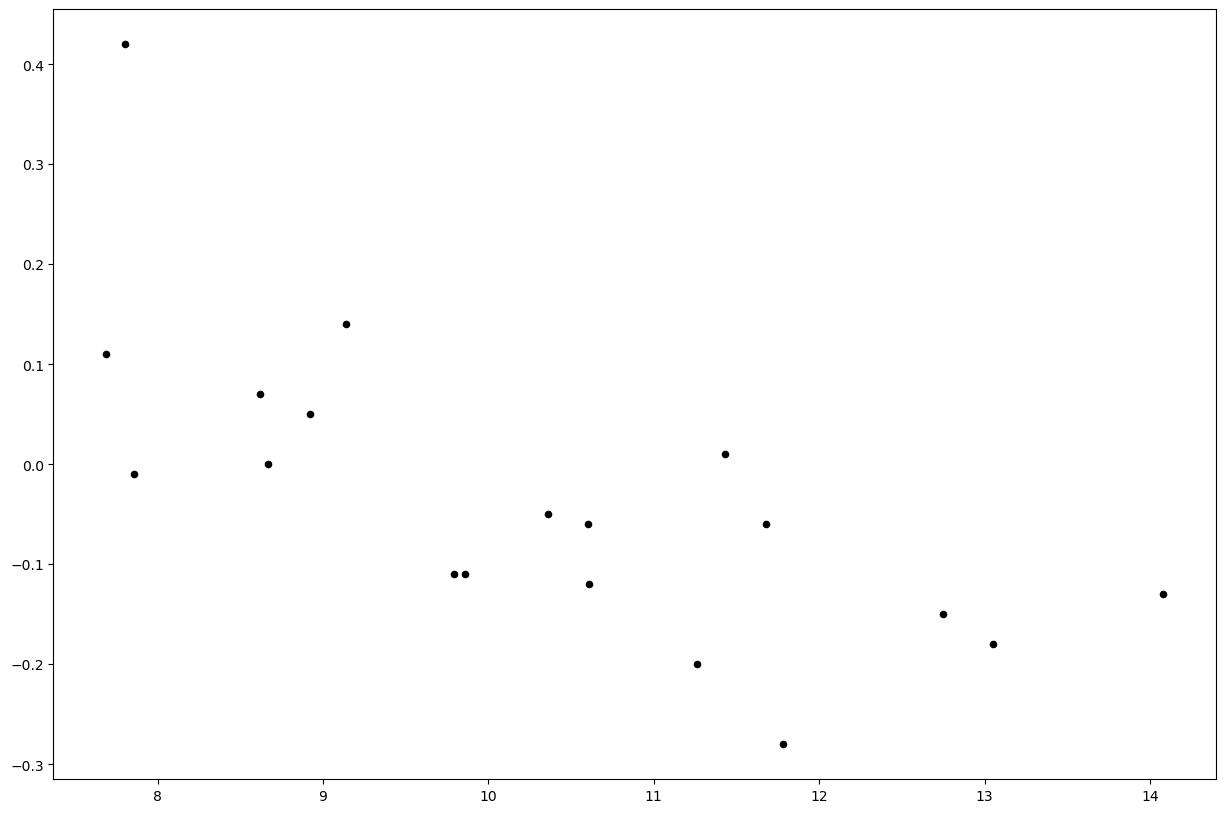

In [3]:
#First let's see what this data looks like
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')

# Cool! The data actually looks pretty linear so we can assume the function we are fitting *is* linear

In [4]:
# let's make a linear function the normal way
def linear(x, m, b):
    return m * x + b

raw:  -0.05818663749944188 0.5653511377902967
raw:  [ 0.00020654 -0.00213008] [-0.00213008  0.02264763]


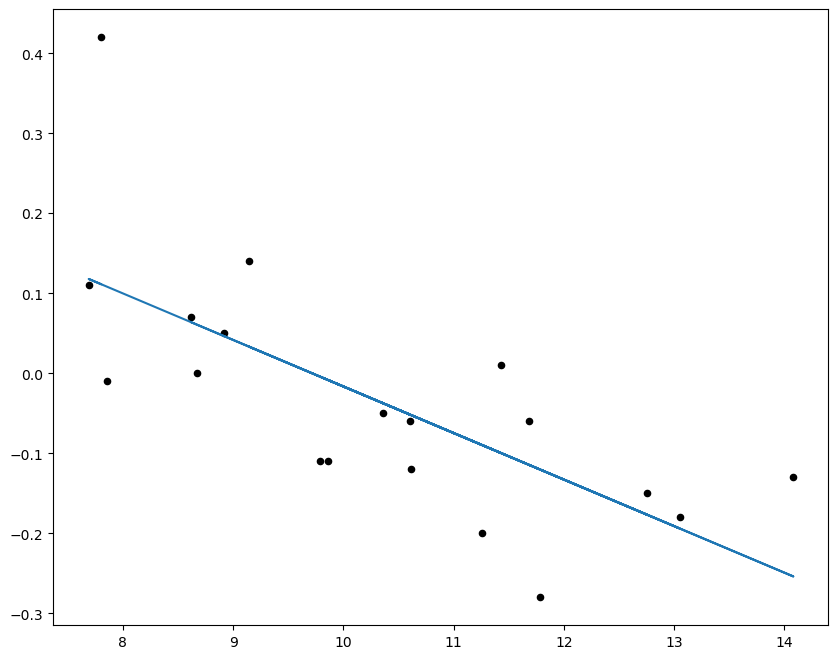

In [5]:
# let's do a linear fit to the data

popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)
print("raw: ", *pcov)


fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black')
ax.plot(data['X'],linear(data['X'], *popt))


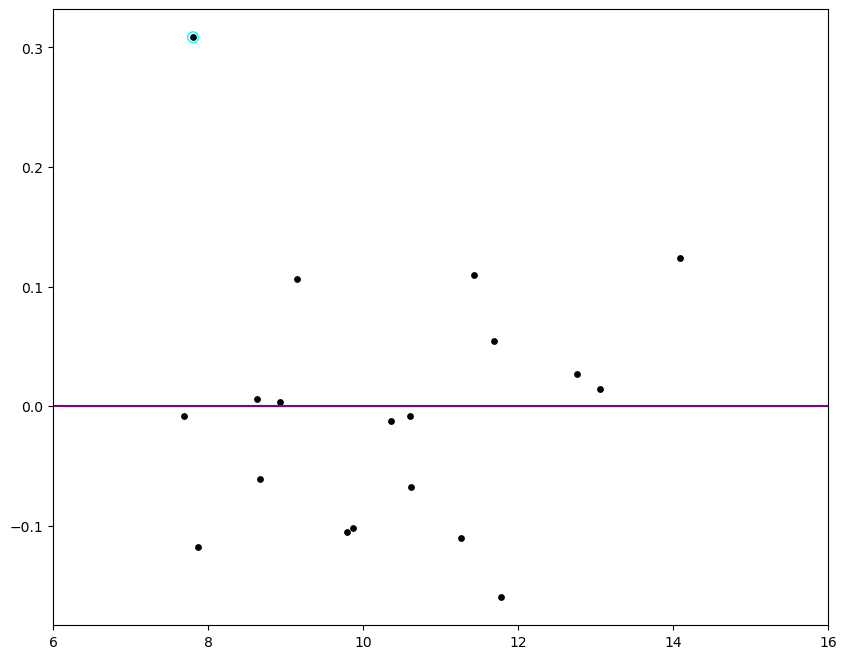

In [6]:
#Let's look into which data are way off the fit.

residual = data['Y']-linear(data['X'],*popt)
x = np.linspace(5,20,1000)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.scatter(data['X'],residual,s=15,c='black')
ax.plot(x,x*0.0,color='purple')
ax.set_xlim(6,16)

outlier = np.absolute(residual)>0.2
ax.scatter(data['X'][outlier],residual[outlier],s=60,edgecolor='cyan',facecolor='none')


raw:  -0.05818663749944188 0.5653511377902967
outliers accounted for:  -0.04338146805673531 0.3967292540601484


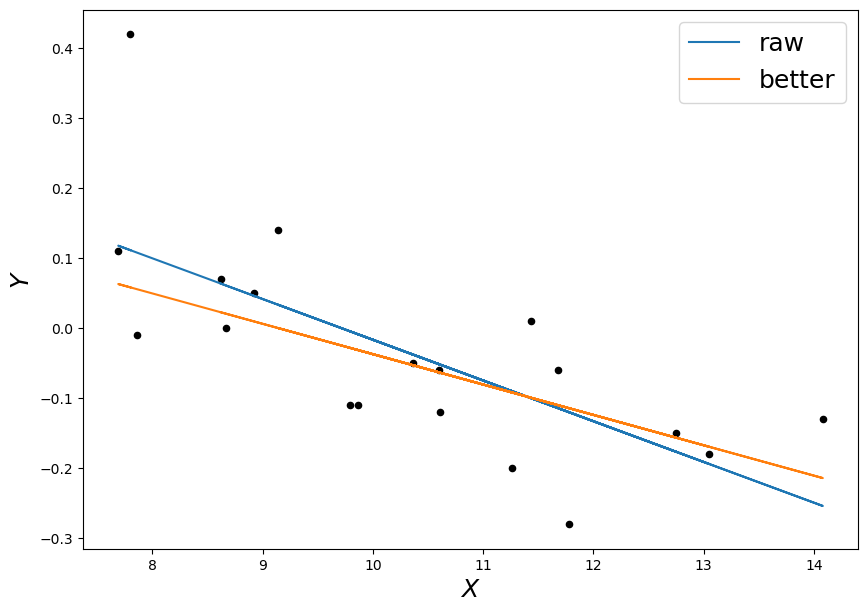

In [7]:
# our values for the raw data above:
# slope:    -0.058187
# intercept: 0.565351
popt, pcov = opt.curve_fit(linear, data['X'], data['Y'])
print("raw: ", *popt)

# we can use curve_fit to de-weight outliers automatically

# note, result is dependent on choice of loss function
# need to see method to trf in order to use least_squares instead of leastsq
popt_clean, pcov = opt.curve_fit(linear, data['X'], data['Y'], method='trf', 
                                 loss='arctan', f_scale=0.20)
print("outliers accounted for: ", *popt_clean)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
# cleaner error bars than last time, play around with the parameters
#ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
#            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

-0.038335615619586275 0.3463734445963487


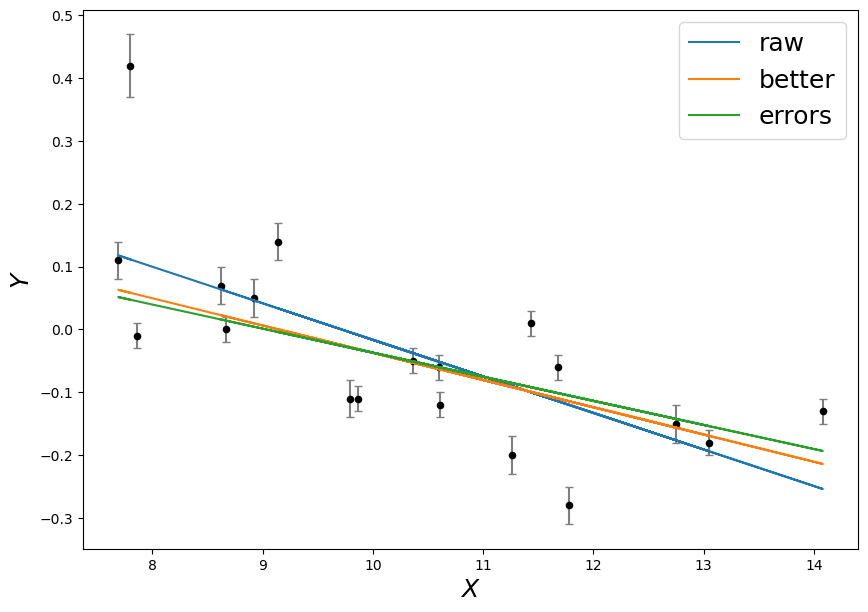

In [8]:
# lets account for the errors
# by pasing sigma, scipy knows to weight data according to their errors 
# naturally, sigma is expected to be the same size and correspond to y
# notice: this only accounts for y error
popt_err, pcov = opt.curve_fit(linear, data['X'], data['Y'], sigma=data['Y_ERR'])
print(*popt_err)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'],data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with out fits
ax.plot(data['X'],linear(data['X'], *popt), label='raw')
ax.plot(data['X'],linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'],linear(data['X'], *popt_err), label='errors')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

mean slope: -0.0585, mean intercept: 0.5683


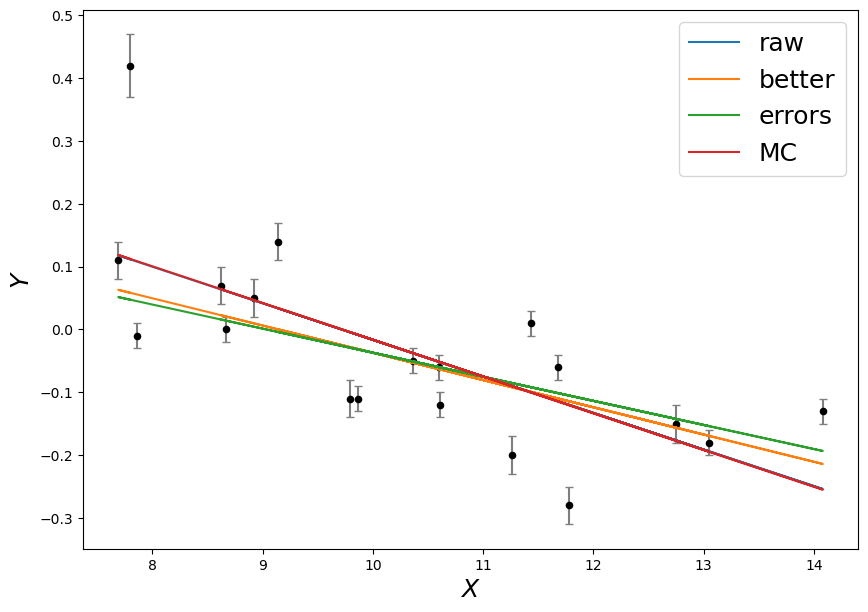

In [9]:
# Does this accurately explore the parameter space though?
# And what is the uncertainty on our data?
# What if we had x error bars?

# we'll explore a method utilizing the common "monte carlo" approach
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weights = np.random.randn(len(y))

        y_adj = y + y_err*weights
        x_adj = x  

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'])

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

In [10]:
# oh right, that outlier.

mask = data['Y'] < 0.3

xdat = data['X'][mask]
ydat = data['Y'][mask]
ydat_err = data['Y_ERR'][mask]

print("data size: ", len(xdat))

slope, intercept = mcFit(xdat, ydat, ydat_err)

print('slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.std(slope),
                                                                          np.mean(intercept)))
print("\n")
# lets discuss monte carlo methods a little
for i in range(20):
    slope, intercept = mcFit(xdat, ydat, ydat_err)
    print("slope: {:+7.4f} $\pm$ {:6.4f}, mean intercept: {:6.4f}".format(np.mean(slope), np.std(slope), 
                                                                          np.mean(intercept)))

# so what we see that our answer changes slightly, but its within the standard deviation
# of each set of measurements. So we can quote a reliable answer, with a reliable uncertainty

data size:  18
slope: -0.0436 $\pm$ 0.0031, mean intercept: 0.3952


slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3953
slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3943
slope: -0.0433 $\pm$ 0.0032, mean intercept: 0.3922
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3955
slope: -0.0435 $\pm$ 0.0031, mean intercept: 0.3945
slope: -0.0435 $\pm$ 0.0033, mean intercept: 0.3952
slope: -0.0435 $\pm$ 0.0035, mean intercept: 0.3951
slope: -0.0436 $\pm$ 0.0033, mean intercept: 0.3958
slope: -0.0435 $\pm$ 0.0034, mean intercept: 0.3946
slope: -0.0435 $\pm$ 0.0034, mean intercept: 0.3951
slope: -0.0436 $\pm$ 0.0034, mean intercept: 0.3963
slope: -0.0436 $\pm$ 0.0034, mean intercept: 0.3964
slope: -0.0437 $\pm$ 0.0032, mean intercept: 0.3970
slope: -0.0436 $\pm$ 0.0034, mean intercept: 0.3953
slope: -0.0437 $\pm$ 0.0032, mean intercept: 0.3966
slope: -0.0433 $\pm$ 0.0033, mean intercept: 0.3927
slope: -0.0437 $\pm$ 0.0034, mean intercept: 0.3967
slope: -0.0435 $\pm$ 0.0035, mean intercept: 0.

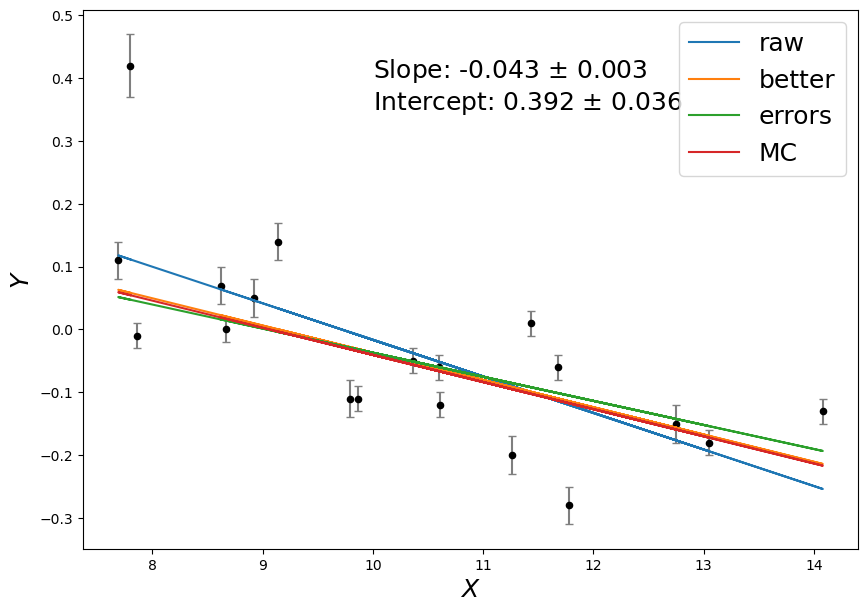

In [11]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'], data['Y'],yerr=data['Y_ERR'], c='tab:gray', 
            fmt='.', markersize=1, capsize=3 ,zorder=0)

slope, intercept = mcFit(xdat, ydat, ydat_err)

# along with out fits
ax.plot(data['X'], linear(data['X'], *popt), label='raw')
ax.plot(data['X'], linear(data['X'], *popt_clean), label='better')
ax.plot(data['X'], linear(data['X'], *popt_err), label='errors')
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='MC')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

ax.text(10, 0.4, "Slope: {:+5.3f} $\pm$ {:5.3f}".format(np.mean(slope), np.std(slope)), fontsize=18)
ax.text(10, 0.35, "Intercept: {:5.3f} $\pm$ {:5.3f}".format(np.mean(intercept), np.std(intercept)), fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

## Homework #10

**REMINDER:** *All coding assignment will be turned in as .ipynb files, to the same PHYS_X0223 repository on GitHub.*   
*They should be turned in with the following naming:*
    
    Lastname_Firstinitial_23_HW10.ipynb

### Problem 1:
We can't know the x data perfectly suppose the data have uniform x errors of 0.5 use the MC technique to estimate the slope *AND* the uncertainty taking into account these errors.



mean slope: -0.0546, mean intercept: 0.5280


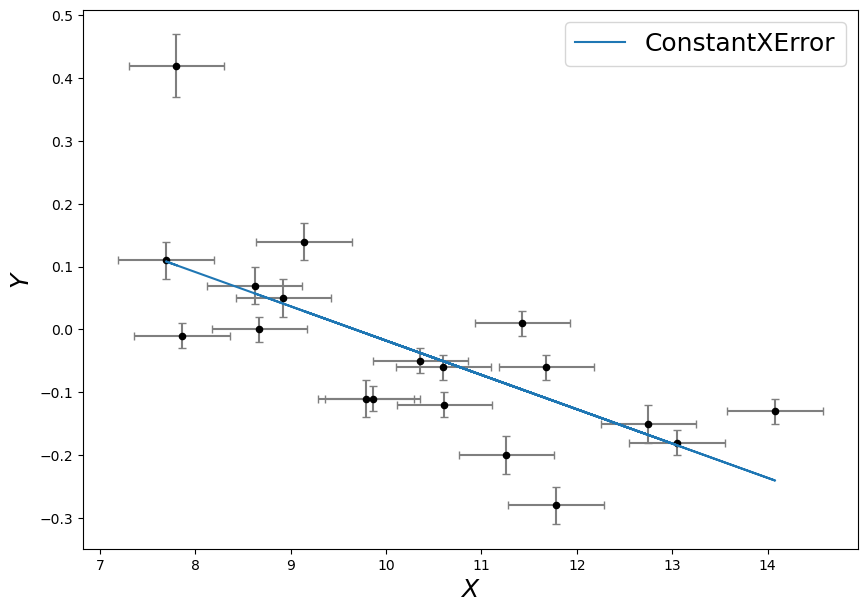

In [61]:
# code here
X_ERR = 0.5
def mcFit(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + 0.5*weightsx 

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'] )

print('mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],  data['Y'], xerr=0.5, yerr=data['Y_ERR'], c='tab:gray', fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='ConstantXError')

ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

### Problem 2:
Repeat problem #1 , but change the errors INCREASE as we move away from X = 8 (as they do) to be precise: suppose X_ERR = |x - 8| /10, e.g. it increases by .1 per unit.

Plot both slopes (Problem 1 & 2). How does the fit change? 

mean slope: -0.0567, mean intercept: 0.5500
mean slope: -0.0574, mean intercept: 0.5574


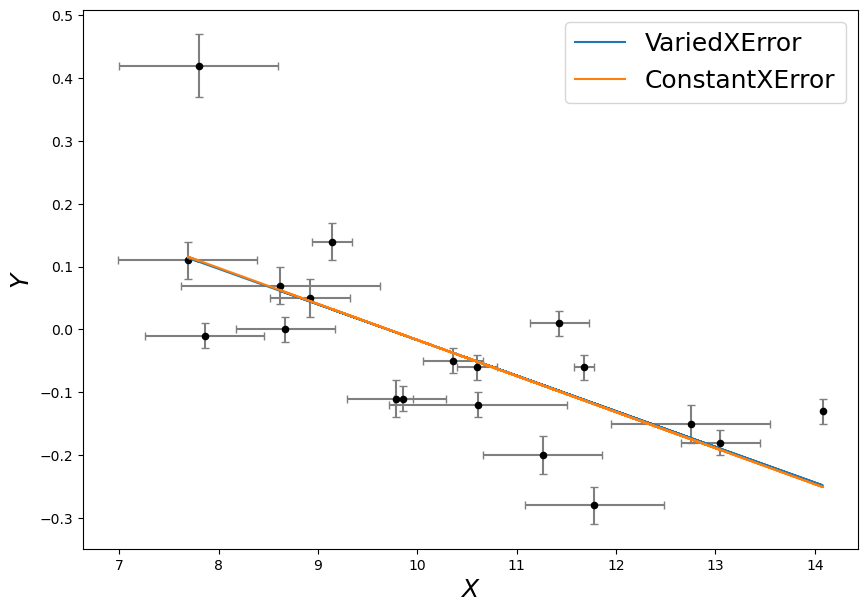

In [55]:
# code here
errx = []
def xerror(x):
    return (abs(x-8))/10
for x in range(len(data['X'])):
        errx.append(xerror(x))
def mcFit1(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + ((abs(x-8))/10)*weightsx

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Y'], data['Y_ERR'] )
 
def mcFit2(x, y, y_err):
    slopes2 = list()
    y_ints2 = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + 0.5*weightsx 

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes2.append(params[0])
        y_ints2.append(params[1])

    return slopes2, y_ints2
        
slope2, intercept2 = mcFit(data['X'], data['Y'], data['Y_ERR'] )

print('for varied error: mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
print('for constant error: mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope2), np.mean(intercept2)))
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Y'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],  data['Y'], xerr=errx, yerr=data['Y_ERR'], c='tab:gray', fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='VariedXError')
ax.plot(data['X'], linear(data['X'], np.mean(slope2), np.mean(intercept2)), label='ConstantXError')
ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Y$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()

### Problem 3: 
Repeat problem 1 & 2, but now anaylze for X vs. Z data, including both uniform 0.5 and X_ERR = |x - 8| /10 uncertainties.

for varied error: mean slope: 0.0059, mean intercept: -0.0606
for constant error: mean slope: 0.0064, mean intercept: -0.0661


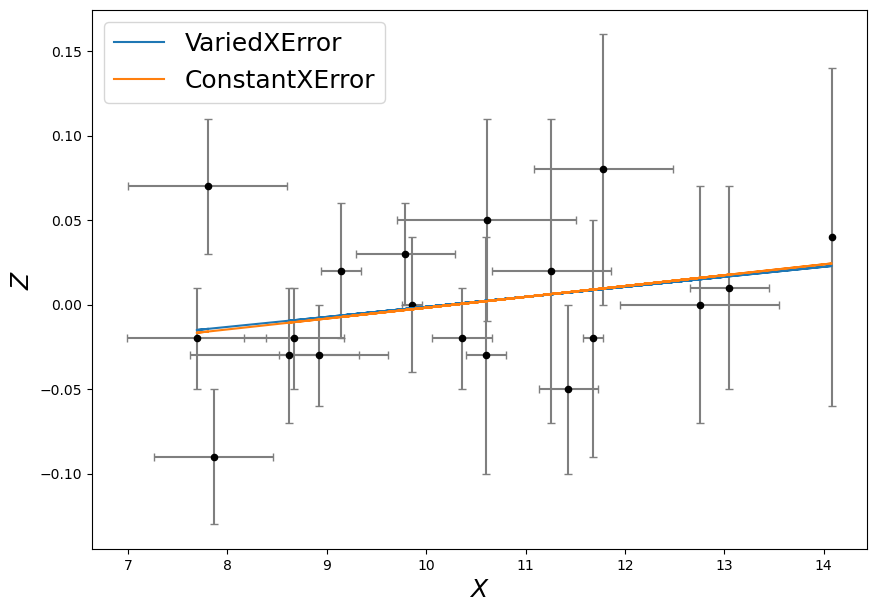

In [59]:
# code here
# code here
errx = []
def xerror(x):
    return (abs(x-8))/10
for x in range(len(data['X'])):
        errx.append(xerror(x))
def mcFit1(x, y, y_err):
    slopes = list()
    y_ints = list()
    iters = 500 
    for i in range(iters):
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + ((abs(x-8))/10)*weightsx

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes.append(params[0])
        y_ints.append(params[1])
    
    return slopes, y_ints

slope, intercept = mcFit(data['X'], data['Z'], data['Z_ERR'] )
 
def mcFit2(x, y, y_err):
    slopes2 = list()
    y_ints2 = list()
    iters = 500 
    for i in range(iters):
        # remember random normal distribution (Gaussian)
        weightsy = np.random.randn(len(y))
        weightsx = np.random.randn(len(y))

        y_adj = y + y_err*weightsy
        x_adj = x + 0.5*weightsx 

        params, other = opt.curve_fit(linear, x_adj, y_adj)
        slopes2.append(params[0])
        y_ints2.append(params[1])

    return slopes2, y_ints2
        
slope2, intercept2 = mcFit(data['X'], data['Z'], data['Z_ERR'] )

print('for varied error: mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope), np.mean(intercept)))
print('for constant error: mean slope: {:6.4f}, mean intercept: {:6.4f}'.format(np.mean(slope2), np.mean(intercept2)))
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.scatter(data['X'], data['Z'],s=20,c='black',zorder=2)
ax.errorbar(data['X'],  data['Z'], xerr=errx, yerr=data['Z_ERR'], c='tab:gray', fmt='.', markersize=1, capsize=3 ,zorder=0)

# along with our fits
ax.plot(data['X'], linear(data['X'], np.mean(slope), np.mean(intercept)), label='VariedXError')
ax.plot(data['X'], linear(data['X'], np.mean(slope2), np.mean(intercept2)), label='ConstantXError')
ax.set_xlabel('$X$', fontsize=18)
ax.set_ylabel('$Z$', fontsize=18)

plt.legend(loc='best', fontsize=18)
plt.show()